In [14]:
import gspread
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.oauth2.service_account import Credentials

In [15]:
SERVICE_ACCOUNT_FILE = '../../key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open("Recheck HC").worksheet("Recheck")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

df.to_csv('../../dataset_qc/recheck_hc.csv')

In [16]:
# cleaning and feature engineering
feature = df.copy()

count_feature = [
    'Count Hasil ASR', 'Count Hasil Pemeriksaan Kualitas', 'Count Efektif',
    'Count Kejelasan Suara', 'Count Suara Lain', 'Count Kelengkapan Rekaman',
    'Count Revisi text']

cols = ['Tanggal Pengerjaan', 'Red Label', *count_feature]

feature[count_feature] = (
    feature[count_feature]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .astype(int)
)

feature['Red Label'] = feature['Red Label'].replace('', 'CLEAR').astype('category')

# Reassigning
feature = feature[cols].copy()
feature['Tanggal Pengerjaan'] = pd.to_datetime(feature['Tanggal Pengerjaan'])

feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21649 entries, 0 to 21648
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Tanggal Pengerjaan                21649 non-null  datetime64[ns]
 1   Red Label                         21649 non-null  category      
 2   Count Hasil ASR                   21649 non-null  int64         
 3   Count Hasil Pemeriksaan Kualitas  21649 non-null  int64         
 4   Count Efektif                     21649 non-null  int64         
 5   Count Kejelasan Suara             21649 non-null  int64         
 6   Count Suara Lain                  21649 non-null  int64         
 7   Count Kelengkapan Rekaman         21649 non-null  int64         
 8   Count Revisi text                 21649 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(7)
memory usage: 1.3 MB


In [17]:
# Dropping last date in the data
feature['Tanggal Pengerjaan'] = pd.to_datetime(feature['Tanggal Pengerjaan'])

last_date = feature['Tanggal Pengerjaan'].max()
feature = feature[feature['Tanggal Pengerjaan'] != last_date]

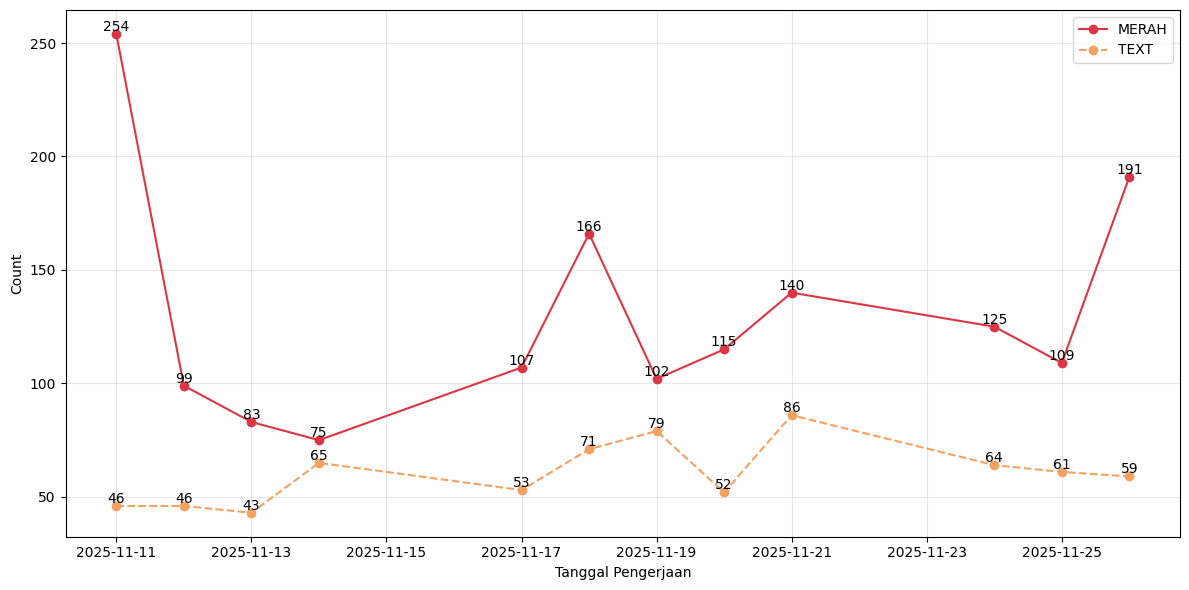

In [18]:
# Filter
red_data = feature[feature['Red Label'].str.upper() == "MERAH"]
text_data = feature[feature['Red Label'].str.upper() == "TEXT"]

# Aggregate by date
red_daily = red_data.groupby('Tanggal Pengerjaan').size()
text_daily = text_data.groupby('Tanggal Pengerjaan').size()

# Plot
plt.figure(figsize=(12, 6))

plt.plot(
    red_daily.index,
    red_daily.values,
    marker='o',
    linestyle='-',
    label='MERAH',
    color='#dc3545'
)

for x, y in zip(red_daily.index, red_daily.values):
    plt.text(x, y, str(y), ha='center', va='bottom'   )

plt.plot(
    text_daily.index,
    text_daily.values,
    marker='o',
    linestyle='--',
    label='TEXT',
    color='#f4a261'
)

for x, y in zip(text_daily.index, text_daily.values):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.title('')
plt.xlabel('Tanggal Pengerjaan')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

In [19]:
# Cleaning data
analysis = df.copy()

analysis['Tanggal Pengerjaan'] = pd.to_datetime(analysis['Tanggal Pengerjaan'], errors='coerce')

# Remove spaces from every data
analysis = analysis.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\ozy.prazuganda\AppData\Local\Temp\ipykernel_17820\2652614333.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  analysis = analysis.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [20]:
# Count compound
comp_call_id = analysis.groupby('Tanggal Pengerjaan')['Call ID '].nunique().cumsum()

ASI = analysis[analysis['ASI/AFI'] == 'ASI']
AFI = analysis[analysis['ASI/AFI'] == 'AFI']

comp_ASI = ASI.groupby('Tanggal Pengerjaan')['Call ID '].nunique().cumsum()
comp_AFI = AFI.groupby('Tanggal Pengerjaan')['Call ID '].nunique().cumsum()

total = analysis.groupby('Tanggal Pengerjaan').size().cumsum()
total_ASI = ASI.groupby('Tanggal Pengerjaan').size().cumsum()
total_AFI = AFI.groupby('Tanggal Pengerjaan').size().cumsum()

# New DF
the_comp = pd.concat([
    comp_call_id.rename('Comp Call ID'),
    comp_ASI.rename('Comp ASI'),
    comp_AFI.rename('Comp AFI'),
    total.rename('Total Call ID'),
    total_ASI.rename('Total ASI'),
    total_AFI.rename('Total AFI')
], axis=1)

the_comp.sort_values('Tanggal Pengerjaan', ascending=False)

,Comp Call ID,Comp ASI,Comp AFI,Total Call ID,Total ASI,Total AFI
Tanggal Pengerjaan,,,,,,
2025-11-27,322,187,136,21649,13823,7826
2025-11-26,293,171,123,19689,12640,7049
2025-11-25,261,148,114,17698,11161,6537
2025-11-24,238,138,101,16287,10332,5955
2025-11-21,210,119,92,14329,8898,5431
2025-11-20,194,108,86,12885,7851,5034
2025-11-19,166,92,74,11441,7094,4347
2025-11-18,138,78,60,9564,6034,3530
2025-11-17,113,65,48,7667,4896,2771


In [21]:
# Count compound
comp_call_id = analysis.groupby('Tanggal Pengerjaan')['Call ID '].nunique()

ASI = analysis[analysis['ASI/AFI'] == 'ASI']
AFI = analysis[analysis['ASI/AFI'] == 'AFI']

comp_ASI = ASI.groupby('Tanggal Pengerjaan')['Call ID '].nunique()
comp_AFI = AFI.groupby('Tanggal Pengerjaan')['Call ID '].nunique()

total = analysis.groupby('Tanggal Pengerjaan').size()
total_ASI = ASI.groupby('Tanggal Pengerjaan').size()
total_AFI = AFI.groupby('Tanggal Pengerjaan').size()

# New DF
the_comp = pd.concat([
    comp_call_id.rename('Comp Call ID'),
    comp_ASI.rename('Comp ASI'),
    comp_AFI.rename('Comp AFI'),
    total.rename('Total Call ID'),
    total_ASI.rename('Total ASI'),
    total_AFI.rename('Total AFI')
], axis=1)

the_comp.sort_values('Tanggal Pengerjaan', ascending=False)

,Comp Call ID,Comp ASI,Comp AFI,Total Call ID,Total ASI,Total AFI
Tanggal Pengerjaan,,,,,,
2025-11-27,29,16,13,1960,1183,777
2025-11-26,32,23,9,1991,1479,512
2025-11-25,23,10,13,1411,829,582
2025-11-24,28,19,9,1958,1434,524
2025-11-21,16,11,6,1444,1047,397
2025-11-20,28,16,12,1444,757,687
2025-11-19,28,14,14,1877,1060,817
2025-11-18,25,13,12,1897,1138,759
2025-11-17,25,11,14,1443,673,770


In [22]:
# Count each day for each categories
analysis.groupby('Tanggal Pengerjaan')['Call ID '].nunique()

Tanggal Pengerjaan
2025-11-11    23
2025-11-12    26
2025-11-13    22
2025-11-14    17
2025-11-17    25
2025-11-18    25
2025-11-19    28
2025-11-20    28
2025-11-21    16
2025-11-24    28
2025-11-25    23
2025-11-26    32
2025-11-27    29
Name: Call ID , dtype: int64

In [23]:
analysis[analysis['Tanggal Pengerjaan'] == '2025-11-26'].groupby('ASI/AFI')['Call ID '].nunique()

ASI/AFI
AFI     9
ASI    23
Name: Call ID , dtype: int64

In [24]:
unique_rows = (
    analysis[analysis['Tanggal Pengerjaan'] == '2025-11-24']
    .drop_duplicates(subset=['Nama Agent ', 'Call ID '])
    .sort_values(['Nama Agent ', 'Call ID '])
)

duplicate_callid_across_agents = (
    unique_rows.groupby('Call ID ')['Nama Agent ']
    .nunique()
    .reset_index()
)

duplicate_callid_across_agents = duplicate_callid_across_agents[
    duplicate_callid_across_agents['Nama Agent '] > 1
]

detail_duplicate = unique_rows[
    unique_rows['Call ID '].isin(duplicate_callid_across_agents['Call ID '])
].sort_values(['Call ID ', 'Nama Agent '])

detail_duplicate

,No,Tanggal Pengerjaan,Nama Agent,ASI/AFI,Waktu Inbound,Nomor Inbound,Nama Agent,Call ID,Durasi Bicara,Detik,...,Kelengkapan Rekaman,Revisi Teks,Red Label,Count Hasil ASR,Count Hasil Pemeriksaan Kualitas,Count Efektif,Count Kejelasan Suara,Count Suara Lain,Count Kelengkapan Rekaman,Count Revisi text
